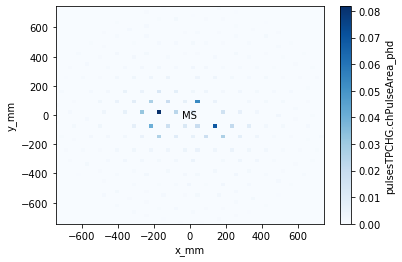

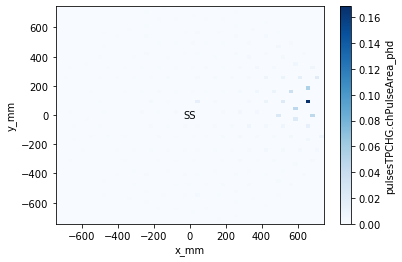

x_train shape: (26751, 64, 64, 1)
26751 train samples
8918 test samples
input shape: (64, 64, 1)


In [9]:
import h5py
import numpy as np
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras import initializers as ki
from tensorflow.keras.metrics import AUC, Accuracy
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt

with np.load('lzap_PMT_images_electrons.npz') as in_file:
    images_array_raw = np.array(in_file["Images"])
    truth_array_raw = np.array(in_file["Truth"])-1
    truthpos_array_raw = np.array(in_file["TruthPos"])
    trutheng_array_raw = np.array(in_file["TruthEng"])
pmt_pos = np.genfromtxt("tpc_pmt_pos.csv", delimiter=',', skip_header=False)
#select top only                                                                                                                                                                         
top=pmt_pos[:,0]<253

#select x and y only                                                                                                                                                                     
pmt_num=pmt_pos[:,0][top]
x=pmt_pos[:,5][top]
y=pmt_pos[:,6][top]
xedges = np.linspace(np.min(x)-13,np.max(x)+13,num=64)
yedges = xedges
ms=False
ss=False
for evt_id in range(len(truth_array_raw)):
    if ms and ss: break
    if truth_array_raw[evt_id]==1:
        if ms: continue
        multiplicity = "MS"
        ms = True
    else:
        if ss:continue
        multiplicity = "SS"
        ss = True
    H = images_array_raw[evt_id]/np.sum(images_array_raw[evt_id])
    X, Y = np.meshgrid(xedges, yedges)
    im = plt.pcolormesh(X, Y, H, cmap="Blues")                                                                                                                                                
    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel('pulsesTPCHG.chPulseArea_phd')
    plt.text(0.5, 0.5, multiplicity, horizontalalignment='center',verticalalignment='center')
    plt.xlabel("x_mm")
    plt.ylabel("y_mm")
    # plt.xlim(np.min(pos_x)-200,np.max(pos_x)+200)                                                                                                                                      
    # plt.ylim(np.min(pos_y)-200,np.max(pos_y)+200)                                                                                                                                      
    plt.show()

batch_size = 128
num_classes = 2
engthreshold = 0
r_up = 9999
r_low = 0
#0-8
###
##Set epochs
###
images_array = []
truth_array = []
truthpos_array = []
trutheng_array = []
for i in range(len(truth_array_raw)):
        if truthpos_array_raw[i,1,0]==-999:
                if (trutheng_array_raw[i,0]>engthreshold):
                    images_array.append(np.array(images_array_raw[i]))
                    truth_array.append(truth_array_raw[i])
                    truthpos_array.append(np.array(truthpos_array_raw[i]))
                    trutheng_array.append(np.array(trutheng_array_raw[i]))
        else:
                #only keep ms with two clusters with radial distance>r mm and energy deposit >3keV
                if ((truthpos_array_raw[i,0,0]-truthpos_array_raw[i,1,0])**2+(truthpos_array_raw[i,0,1]-truthpos_array_raw[i,1,1])**2>r_low**2 and (truthpos_array_raw[i,0,0]-truthpos_array_raw[i,1,0])**2+(truthpos_array_raw[i,0,1]-truthpos_array_raw[i,1,1])**2<r_up**2):
                        if (trutheng_array_raw[i,0]>engthreshold and trutheng_array_raw[i,1]>engthreshold):
                            images_array.append(np.array(images_array_raw[i]))
                            truth_array.append(truth_array_raw[i])
                            truthpos_array.append(np.array(truthpos_array_raw[i]))
                            trutheng_array.append(np.array(trutheng_array_raw[i]))
#print (np.shape(truth_array),np.shape(truthpos_array),np.shape(images_array))
#print (type(truth_array[0]),type(truthpos_array[0][0]),type(images_array[0][0]))
#print (truth_array,images_array)
truthpos_array = np.array(truthpos_array)
trutheng_array = np.array(trutheng_array)
images_array = np.array(images_array)
truthpos_array = [x for _,x in sorted(zip(truth_array,truthpos_array.tolist()))] 
trutheng_array = [x for _,x in sorted(zip(truth_array,trutheng_array.tolist()))] 
images_array = [x for _,x in sorted(zip(truth_array,images_array.tolist()))]  
truth_array = np.array(sorted(truth_array)) 
nkeep = len(truth_array[truth_array==2])

images_array = images_array[-2*nkeep:]                                                       
truth_array = truth_array[-2*nkeep:]                                                                             
truthpos_array = truthpos_array[-2*nkeep:] 
trutheng_array = trutheng_array[-2*nkeep:]
#truth_array,truthpos_array,images_array = zip(*sorted(zip(truth_array,truthpos_array,images_array)))    
# input image dimensions
img_rows, img_cols = len(images_array[0]), len(images_array[0][0])

# spliting the data between train and test
# randomise the data and seperate
indices = np.random.permutation(np.shape(images_array)[0])
truth_array = np.array(truth_array)
truthpos_array = np.array(truthpos_array)
trutheng_array = np.array(trutheng_array)
images_array = np.array(images_array)
###
#75:25 train:test
###
train_len=int(np.floor(len(images_array)*.75))

training_idx, test_idx = indices[:train_len], indices[train_len:]

x_train, x_test, pos_test  = images_array[training_idx,:,:], images_array[test_idx,:,:], truthpos_array[test_idx]
y_train, y_test  = truth_array[training_idx], truth_array[test_idx]


#if K.image_data_format() == 'channels_first':
 #   x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
  #  x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
   # input_shape = (1, img_rows, img_cols)
#else:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
#i think our is always channels_last

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
for i in range(len(x_train)):
    x_train[i] = x_train[i]/np.sum(x_train[i])
for i in range(len(x_test)):
    x_test[i] = x_test[i]/np.sum(x_test[i])

#max_image_value=np.max(images_array[:,:,:])
#x_train /= max_image_value
#x_test /= max_image_value
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('input shape:', input_shape)
# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)



In [4]:
import seaborn as sns
import pandas as pd
gpts = (truth_array==1)
truth_r = np.sqrt((truthpos_array[gpts,0,0]-truthpos_array[gpts,1,0])**2+(truthpos_array[gpts,0,1]-truthpos_array[gpts,1,1])**2)
truth_r = np.array([[i] for i in truth_r])
#print (np.shape(truth_r),np.shape(trutheng_array[gpts]),np.shape(truthpos_array[gpts,0]))
df = pd.DataFrame(np.concatenate((np.concatenate((np.concatenate((truthpos_array[gpts,0], truthpos_array[gpts,1]), axis=1),trutheng_array[gpts]),axis=1),truth_r),axis=1),columns=['x0_mm','y0_mm','z0_mm','x1_mm','y1_mm','z1_mm','eng0_keV','eng1_keV','deltaR_mm'])
#print(df)
variable_names = ['deltaR_mm','z0_mm','z1_mm','eng0_keV','eng1_keV']

# Make a new column where the answer is a category with the appropriate name, for plotting
#df['answer']='Kr83'
#df.loc[y_df==1,'answer']='DD'
#df['answer'] = df['answer'].astype('category')

# Plot input distributions and visualize correlations; only look at a subset of events for scatter plotting
g = sns.pairplot(df.head(2000), vars=variable_names,height=3) # Diagonal plots are smoothed using kernel density estimator

ModuleNotFoundError: No module named 'seaborn'

In [10]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.models import load_model

class EpochCallback(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        score_train = self.model.evaluate(x_train, y_train, verbose=0)
        score_test = self.model.evaluate(x_test, y_test, verbose=0)
        test_scores.append(score_test)
        train_scores.append(score_train)
        print ("train score:",score_train,"test score:",score_test)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adadelta(),
              metrics=['accuracy'])
epochs = 100
test_scores=[]
train_scores=[]
history=model.fit(x_train,  y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[EpochCallback()])
'''score = model.evaluate(x_test, y_test, verbose=0)
score_train = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score_train[0])
print('Train accuracy:', score_train[1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])'''
test_scores = np.array(test_scores)
train_scores = np.array(train_scores)

Epoch 1/100
209/209 [==============================] - 231s 1s/step - loss: 0.6928 - accuracy: 0.5730 - val_loss: 0.6921 - val_accuracy: 0.5701
Epoch 2/100
209/209 [==============================] - 226s 1s/step - loss: 0.6917 - accuracy: 0.5820 - val_loss: 0.6909 - val_accuracy: 0.5665
Epoch 3/100
209/209 [==============================] - 223s 1s/step - loss: 0.6907 - accuracy: 0.5683 - val_loss: 0.6899 - val_accuracy: 0.5665
Epoch 4/100
209/209 [==============================] - 227s 1s/step - loss: 0.6898 - accuracy: 0.5652 - val_loss: 0.6889 - val_accuracy: 0.5665
Epoch 5/100
209/209 [==============================] - 224s 1s/step - loss: 0.6889 - accuracy: 0.5645 - val_loss: 0.6880 - val_accuracy: 0.5665
Epoch 6/100
209/209 [==============================] - 226s 1s/step - loss: 0.6879 - accuracy: 0.5635 - val_loss: 0.6870 - val_accuracy: 0.5665
Epoch 7/100
209/209 [==============================] - 228s 1s/step - loss: 0.6871 - accuracy: 0.5639 - val_loss: 0.6860 - val_accuracy:

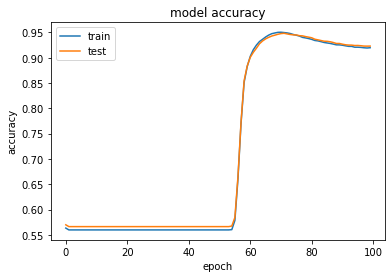

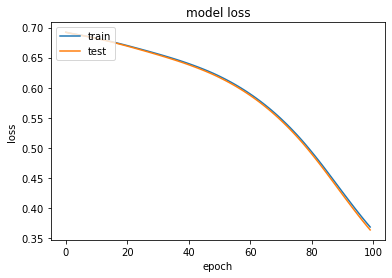

In [11]:
from tensorflow.keras.models import load_model
model.save('cori_electrons_epoch100_weighted_r>0mm_E>0keV_shuffled_normdata.h5')
#model = load_model('dd_epoch100_weighted_r>0mm_E>0keV_shuffled_normdata.h5')
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.plot(train_scores[:,1])
plt.plot(test_scores[:,1])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#print (train_scores[:,1],test_scores[:,1])
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.plot(train_scores[:,0])
plt.plot(test_scores[:,0])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
from tensorflow.keras.models import load_model
#model = load_model('dd_epoch10_weighted_r>0mm_E>0keV_shuffled.h5')
prediction  = model.predict(x_test) 

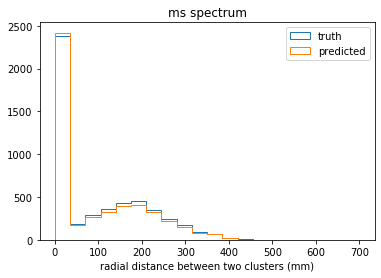

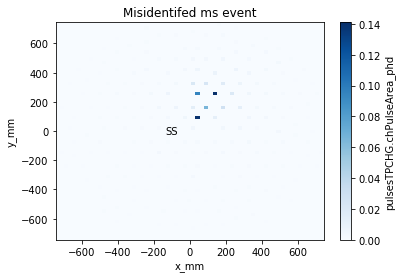

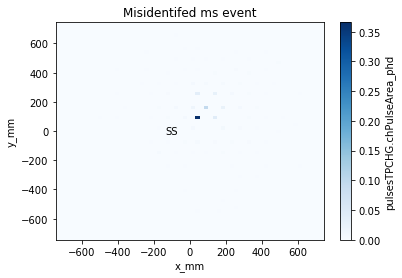

In [13]:
predicted_value = []
truth_value = []
for i in range(len(x_test)):
    predicted_value.append(np.argmax(prediction[i]))
    truth_value.append(np.argmax(y_test[i]))
predicted_value = np.array(predicted_value)
truth_value = np.array(truth_value)

deltaR_test = np.sqrt((pos_test[:,0,0]-pos_test[:,1,0])**2+(pos_test[:,0,1]-pos_test[:,1,1])**2)
deltaR_test[deltaR_test>700] = 0
predicted_ms = predicted_value==1
truth_ms = truth_value==1

plt.hist(deltaR_test[truth_ms], bins=20,range=(0,700), label="truth",histtype="step")
plt.hist(deltaR_test[predicted_ms], bins=20, range=(0,700),label="predicted",histtype="step")
plt.legend(loc="upper right")
plt.title("ms spectrum")
plt.xlabel("radial distance between two clusters (mm)")

plt.figure()
pmt_pos = np.genfromtxt("tpc_pmt_pos.csv", delimiter=',', skip_header=False)
#select top only                                                                                                                                                                         
top=pmt_pos[:,0]<253

#select x and y only                                                                                                                                                                     
pmt_num=pmt_pos[:,0][top]
x=pmt_pos[:,5][top]
y=pmt_pos[:,6][top]
xedges = np.linspace(np.min(x)-13,np.max(x)+13,num=64)
yedges = xedges
gpts = np.logical_and(truth_value!=predicted_value, truth_value==0)
x_test_miss = x_test[gpts]
for evt_id in range(len(x_test_miss[:2])):
    H = x_test_miss[evt_id].reshape(64,64)       
    X, Y = np.meshgrid(xedges, yedges)
    im = plt.pcolormesh(X, Y, H, cmap="Blues")                                                                                                                                                
    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel('pulsesTPCHG.chPulseArea_phd')     
    plt.xlabel("x_mm")
    plt.ylabel("y_mm")
    plt.text(-100, -1,"SS", horizontalalignment='center',verticalalignment='center')
    plt.title("Misidentifed ms event")
    plt.show()

In [34]:
#plot_model(model, to_file='model.png')


In [14]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
import tensorflow.keras
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import glob

with np.load('lzap_PMT_images_moreelectrons.npz') as in_file:
    images_array_raw = np.array(in_file["Images"])
    truth_array_raw = np.array(in_file["Truth"])-1
    truthpos_array_raw = np.array(in_file["TruthPos"])
    trutheng_array_raw = np.array(in_file["TruthEng"])
    mercury_array_raw = np.array(in_file["XYchi2"])

engthreshold = 0
r_up = 9999
r_low = 0
images_array = []
truth_array = []
truthpos_array = []
trutheng_array = []
mercury_array = []
for i in range(len(truth_array_raw)):
        if truthpos_array_raw[i,1,0]==-999:
                if (trutheng_array_raw[i,0]>engthreshold):
                    images_array.append(np.array(images_array_raw[i]))
                    truth_array.append(truth_array_raw[i])
                    truthpos_array.append(np.array(truthpos_array_raw[i]))
                    trutheng_array.append(np.array(trutheng_array_raw[i]))
                    mercury_array.append(mercury_array_raw[i])
        else:
                #only keep ms with two clusters with r_up>radial distance>r_low mm and energy deposit >engthreshold
                if ((truthpos_array_raw[i,0,0]-truthpos_array_raw[i,1,0])**2+(truthpos_array_raw[i,0,1]-truthpos_array_raw[i,1,1])**2>r_low**2 and (truthpos_array_raw[i,0,0]-truthpos_array_raw[i,1,0])**2+(truthpos_array_raw[i,0,1]-truthpos_array_raw[i,1,1])**2<r_up**2):
                        if (trutheng_array_raw[i,0]>engthreshold and trutheng_array_raw[i,1]>engthreshold):
                            images_array.append(np.array(images_array_raw[i]))
                            truth_array.append(truth_array_raw[i])
                            truthpos_array.append(np.array(truthpos_array_raw[i]))
                            trutheng_array.append(np.array(trutheng_array_raw[i]))
                            mercury_array.append(mercury_array_raw[i])
truthpos_array = np.array(truthpos_array)
trutheng_array = np.array(trutheng_array)
images_array = np.array(images_array)
mercury_array = np.array(mercury_array)
truthpos_array = [x for _,x in sorted(zip(truth_array,truthpos_array.tolist()))] 
trutheng_array = [x for _,x in sorted(zip(truth_array,trutheng_array.tolist()))] 
images_array = [x for _,x in sorted(zip(truth_array,images_array.tolist()))]  
mercury_array = [x for _,x in sorted(zip(truth_array,mercury_array.tolist()))]  
truth_array = np.array(sorted(truth_array)) 
nkeep = len(truth_array[truth_array==2])

images_array = images_array[-2*nkeep:]                                                       
truth_array = truth_array[-2*nkeep:]    
mercury_array = mercury_array[-2*nkeep:]
truthpos_array = truthpos_array[-2*nkeep:] 
trutheng_array = trutheng_array[-2*nkeep:]
img_rows, img_cols = len(images_array[0]), len(images_array[0][0])

# spliting the data between train and test
# randomise the data and seperate
indices = np.random.permutation(np.shape(images_array)[0])
truth_array = np.array(truth_array)
truthpos_array = np.array(truthpos_array)
trutheng_array = np.array(trutheng_array)
images_array = np.array(images_array)
mercury_array = np.array(mercury_array)
###
#75:25 train:test
###
train_len=int(np.floor(len(images_array)*.75))

test_idx = indices[train_len:]

x_test, pos_test, mercury_test  = images_array[test_idx,:,:], truthpos_array[test_idx], mercury_array[test_idx]
y_test  = truth_array[test_idx]


x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_test = x_test.astype('float32')
max_image_value=np.max(images_array[:,:,:])
x_test_unnorm = x_test/max_image_value
for i in range(len(x_test)):
    x_test[i] = x_test[i]/np.sum(x_test[i])
print(x_test.shape[0], 'test samples')
# convert class vectors to binary class matrices
y_test = tensorflow.keras.utils.to_categorical(y_test, 2)

8918 test samples


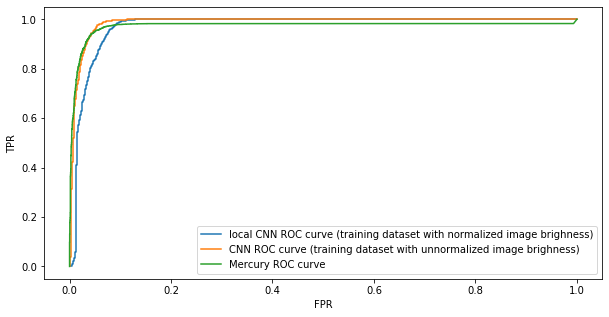

In [15]:
model_unnorm = load_model('cori_electrons_epoch100_weighted_r>0mm_E>0keV_shuffled_unnormdata.h5')
#model = load_model('cori_electrons_epoch100_weighted_r>0mm_E>0keV_shuffled_normdata.h5')
prediction_unnorm  = model_unnorm.predict(x_test_unnorm) 
prediction  = model.predict(x_test) 

y_pred_test = prediction[:,1]
y_pred_unnorm_test = prediction_unnorm[:,1]
CNN_FPR_test, CNN_TPR_test, CNN_TH_test = roc_curve(y_test[:,1], y_pred_test, pos_label=1) # Signal class set to 1
CNN_FPR_unnorm_test, CNN_TPR_unnorm_test, CNN_TH_unnorm_test = roc_curve(y_test[:,1], y_pred_unnorm_test, pos_label=1)
mercury_FPR_test, mercury_TPR_test, mercury_TH_test = roc_curve(y_test[:,1], mercury_test , pos_label=1)
plt.figure(figsize=(10,5))
plt.plot(CNN_FPR_test, CNN_TPR_test, label="local CNN ROC curve (training dataset with normalized image brighness)")
plt.plot(CNN_FPR_unnorm_test, CNN_TPR_unnorm_test, label="CNN ROC curve (training dataset with unnormalized image brighness)")
plt.plot(mercury_FPR_test, mercury_TPR_test, label="Mercury ROC curve")
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()
plt.show()